In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
teams_df = pd.read_csv(f"{DATA_DIR}/MTeams.csv")
seeds_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySeeds.csv")
reg_results_df = pd.read_csv(f"{DATA_DIR}/MRegularSeasonDetailedResults.csv")
tournament_results_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneyCompactResults.csv")

In [4]:
STATS = {
    'Score',
    'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'    
}

SHARED = {
    'Season', 'DayNum', 'NumOT'
}

In [5]:
# Split single W & L row into two rows, one for winner one for loser
games = reg_results_df.to_dict('records')
games_dicts = []
for game in tqdm(games):
    game["LLoc"] = "H" if game["WLoc"] == "A" else "A"
    game["WLoc"] = game["WLoc"] if game["WLoc"] != "N" else "A"
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    w_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_dict = {**both_dict, **w_own_dict, **w_opp_dict, **{"OppTeamID": game["LTeamID"]}}
    l_dict = {**both_dict, **l_own_dict, **l_opp_dict, **{"OppTeamID": game["WTeamID"]}}
    games_dicts.append(w_dict)
    games_dicts.append(l_dict)

100%|██████████| 92832/92832 [00:03<00:00, 24687.60it/s]


In [6]:
# Calculate each teams home and away season averages
games_df = pd.DataFrame(games_dicts)
mean_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
std_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).std().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)

In [7]:
def flip_key(key):
    if key.startswith("Own"):
        return key.replace("Own", "Opp")
    if key.startswith("Opp"):
        return key.replace("Opp", "Own")
    raise ValueError

In [8]:
# Calculate z scores for each game for:
# 1) opp performance (how did my opp do relative to how they do against others?)
# 2) own performance (how did I do relative to how others do against my opp?)
z_dicts = []
opp_keys = [k for k in games_dicts[0].keys() if k.startswith("Opp") and k in mean_df.columns]
own_keys = [k for k in games_dicts[0].keys() if k.startswith("Own") and k in mean_df.columns]
for game in tqdm(games_dicts):
    means = mean_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    stds = std_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    opp_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in opp_keys
    }
    own_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in own_keys
    }
    z_dicts.append({
        **both_dict, **own_stat_dict, **opp_stat_dict,
         **{"OwnTeamID": game["OwnTeamID"], "OppTeamID": game["OppTeamID"]}
    })

 21%|██        | 38868/185664 [00:11<00:45, 3215.43it/s]<ipython-input-8-200af332dc19>:16: RuntimeWarning: invalid value encountered in double_scalars
  f"{k}_Zscore": (
100%|██████████| 185664/185664 [00:56<00:00, 3273.33it/s]


In [9]:
def build_pca(n, df):
    data_scaled = pd.DataFrame(preprocessing.scale(df), columns=df.columns) 
    pca = PCA(n_components=n)
    results = pca.fit_transform(data_scaled)
    return pca, results

In [10]:
# Get season average z scores
z_df = pd.DataFrame(z_dicts)
z_score_mean_df = z_df.groupby(["Season", "OwnTeamID"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
z_score_mean_df["SOS"] = 0 # We are going to calculate this over time

PCA_N = 2

# 1) Calculate Dominance
# 2) Then SOS from Dominance
# 3) Then re-calculate Dominance, including SOS as part of the calculation
# 4) Repeat this until they stabilize (10 iterations is more than enough)
for i in range(10):    
    # Perform PCA
    pca, results = build_pca(n=PCA_N, df=z_score_mean_df)    
    pca_df = pd.DataFrame(
        pca.components_,
        columns=z_score_mean_df.columns,
        index= [f'PCA-{n}' for n in range(PCA_N)]
    )
    print(f'Dominance: {pca_df.T.sort_values(by="PCA-1", key=abs, ascending=False)[:5]["PCA-1"]}\n')
    
    # Calculate Dominance
    summary_df = pd.DataFrame(results, index=z_score_mean_df.index)
    summary_df = summary_df.reset_index().rename(columns={"OwnTeamID": "TeamID", 0:"Offense", 1:"Dominance"})
    summary_df["Dominance"] = -summary_df["Dominance"]
    
    # Calculate SOS from mean Dominance of opponents
    summary_lookup = summary_df.set_index(["Season", "TeamID"])
    sos_scores = []
    for game in games_dicts:
        sos_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "SOS": summary_lookup.at[(game["Season"], game["OppTeamID"]), "Dominance"]
        })
    sos_df = pd.DataFrame(sos_scores).groupby(["Season", "TeamID"]).mean()
    
    # Update original z score data, and run PCA again at the top of the loop
    z_score_mean_df["SOS"] = sos_df["SOS"]
    summary_df = summary_df.merge(
        sos_df, on=["Season", "TeamID"]
    )
    print("Gonzaga example: ", summary_df.set_index(["Season", "TeamID"]).loc[2019, 1211], '\n')

Dominance: OwnScore_Zscore   -0.326426
OwnFGM_Zscore     -0.313468
OwnAst_Zscore     -0.292864
OwnDR_Zscore      -0.277547
OppFTM_Zscore      0.266493
Name: PCA-1, dtype: float64

Gonzaga example:  Offense      1.544842
Dominance    7.883998
SOS          0.573722
Name: (2019, 1211), dtype: float64 

Dominance: OwnScore_Zscore   -0.319940
OwnFGM_Zscore     -0.305832
OwnAst_Zscore     -0.281155
OwnDR_Zscore      -0.273235
SOS               -0.262127
Name: PCA-1, dtype: float64

Gonzaga example:  Offense      1.399084
Dominance    7.812282
SOS          0.758678
Name: (2019, 1211), dtype: float64 

Dominance: OwnScore_Zscore   -0.319692
OwnFGM_Zscore     -0.305721
OwnAst_Zscore     -0.280906
OwnDR_Zscore      -0.272860
SOS               -0.271581
Name: PCA-1, dtype: float64

Gonzaga example:  Offense      1.378118
Dominance    7.830519
SOS          0.754679
Name: (2019, 1211), dtype: float64 

Dominance: OwnScore_Zscore   -0.319656
OwnFGM_Zscore     -0.305674
OwnAst_Zscore     -0.280852
Ow

In [11]:
# Get tournament wins per team
FIRST_ROUND_CUTOFF = 136
results_df = tournament_results_df[tournament_results_df["DayNum"] >= FIRST_ROUND_CUTOFF]
win_count_df = results_df.groupby(["Season", "WTeamID"]).count().reset_index()[["Season", "WTeamID", "DayNum"]]
win_count_df = win_count_df.rename(columns={"WTeamID": "TeamID", "DayNum": "Wins"})
win_count_df

,Season,TeamID,Wins
0,1985,1104,2
1,1985,1116,1
2,1985,1120,2
3,1985,1130,2
4,1985,1181,1
...,...,...,...
1115,2019,1437,1
1116,2019,1438,6
1117,2019,1439,2
1118,2019,1449,1


In [12]:
# Cast seed to int
def get_seed_int(seed):
    numeric_filter = filter(str.isdigit, seed)
    return int("".join(numeric_filter))

seeds_df["SeedInt"] = seeds_df["Seed"].apply(get_seed_int)

In [13]:
# Merge into master DF
tournament_df = teams_df.merge(seeds_df, on="TeamID")[["Season", "TeamID", "TeamName", "Seed", "SeedInt"]]
tournament_df = tournament_df.merge(
    z_score_mean_df.reset_index()[["Season", "OwnTeamID", "OwnScore_Zscore", "OppScore_Zscore"]],
    left_on=["Season", "TeamID"],
    right_on=["Season", "OwnTeamID"]
).drop("OwnTeamID", axis=1)
tournament_df = tournament_df.merge(summary_df, on=["Season", "TeamID"])
tournament_df = tournament_df.merge(win_count_df, on=["Season", "TeamID"], how="left").fillna(0)
is_champion = tournament_df["Wins"] >= 6

In [14]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    for index in range(len(x)):
         p1.text(
             x.iloc[index]+0.02, y.iloc[index], 
             labelseries.iloc[index], size=labelsize, color=labelcolor
         )
    return p1

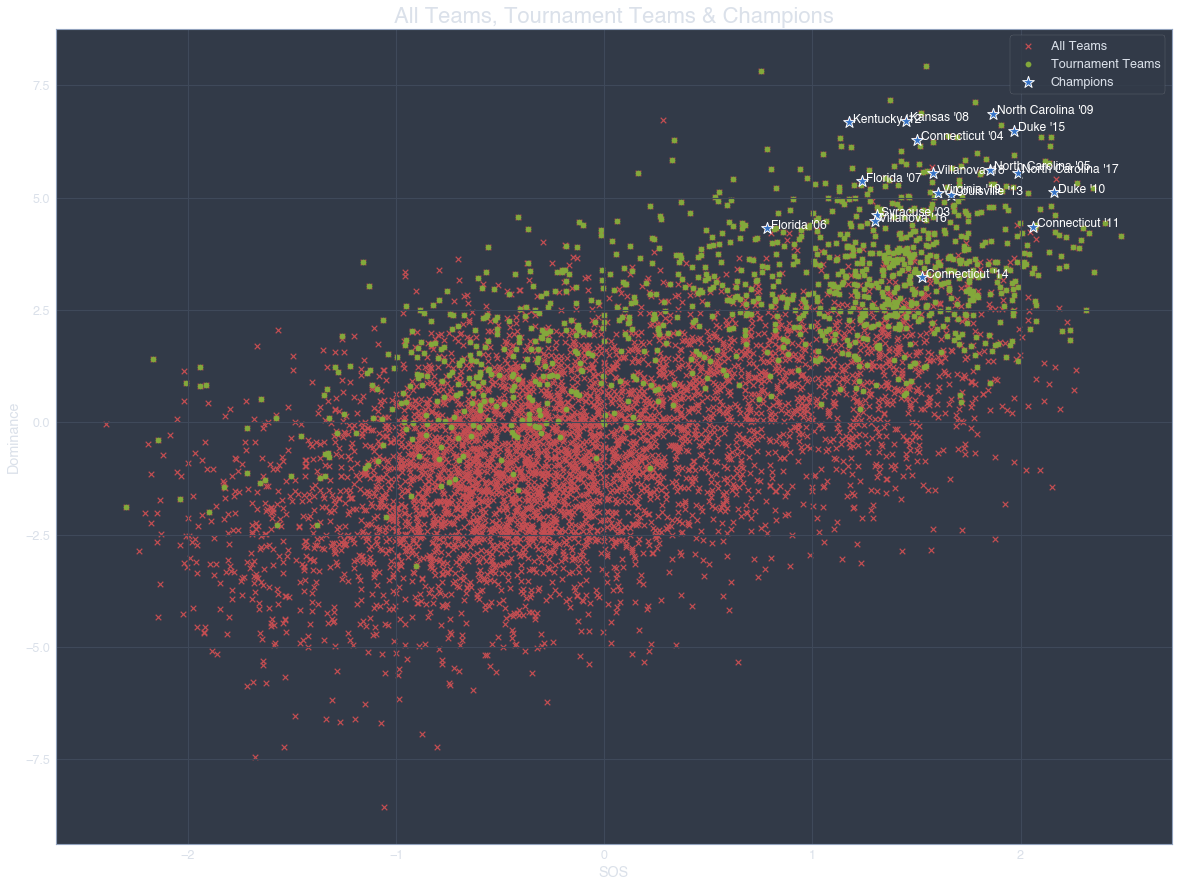

In [15]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["SOS"], summary_df["Dominance"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["SOS"], tournament_df["Dominance"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["SOS"], tournament_df[is_champion]["Dominance"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend();

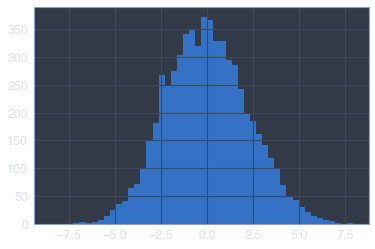

In [16]:
# Dominance follows a normal curve
plt.hist(summary_df["Dominance"], bins=50);

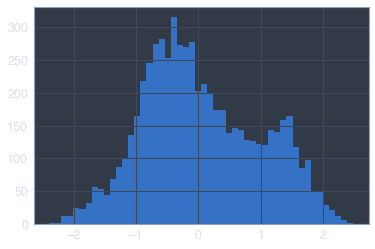

In [17]:
# SOS is a mix of two bell curves (one for elite teams and one for the rest)
plt.hist(summary_df["SOS"], bins=50);

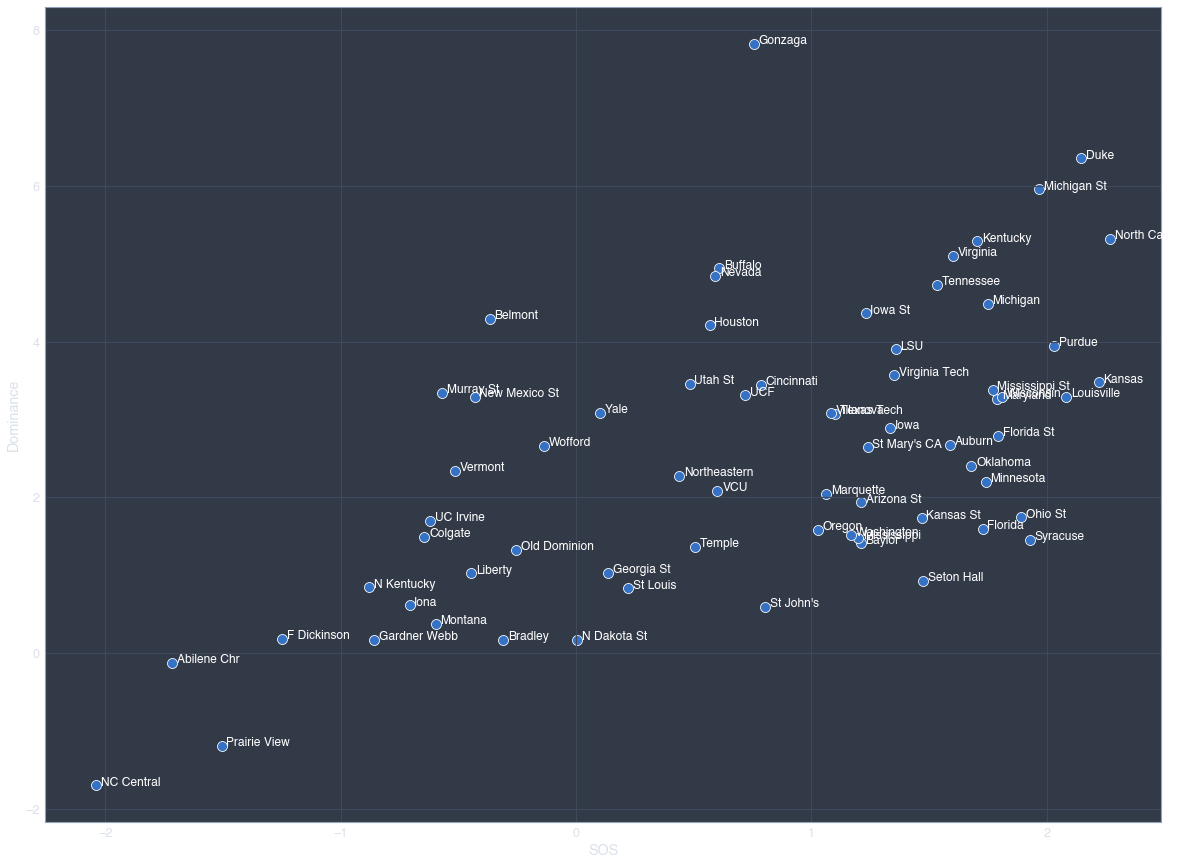

In [18]:
YEAR = 2019
is_year = tournament_df["Season"] == YEAR
plt.figure(figsize=(20,15));
scatter_text(
    x=tournament_df[is_year]["SOS"], y=tournament_df[is_year]["Dominance"], s=100,
    labelseries=tournament_df[is_year]["TeamName"], labelcolor="white"
);

In [19]:
# Top 25 Dominant teams
tournament_df.sort_values("Dominance", ascending=False)[:25]

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,SOS,Wins
618,2012,1314,North Carolina,X01,1,1.258281,-0.190440,4.596917,7.932855,1.545907,3.0
305,2019,1211,Gonzaga,X01,1,1.398097,-0.598454,1.381132,7.827967,0.754181,3.0
403,2015,1246,Kentucky,Y01,1,0.743464,-1.188320,-1.787747,7.183159,1.372484,4.0
167,2009,1163,Connecticut,Z01,1,0.702132,-0.553949,1.273374,7.126883,1.778900,4.0
1104,2015,1458,Wisconsin,Z01,1,0.527952,-0.998001,-6.115843,6.891664,1.521932,5.0
616,2009,1314,North Carolina,X01,1,1.570146,0.200302,6.195879,6.861992,1.866860,6.0
369,2008,1242,Kansas,X01,1,1.024545,-0.621341,1.141511,6.706947,1.448561,6.0
401,2012,1246,Kentucky,Y01,1,0.912072,-0.785912,-0.260683,6.676735,1.177026,6.0
222,2018,1181,Duke,X02,2,1.139815,-0.258810,2.612779,6.611031,1.905156,3.0
219,2015,1181,Duke,X01,1,1.226041,-0.252453,1.817351,6.484809,1.969791,6.0


In [20]:
tournament_df.to_csv(f"{DATA_DIR}/output/teams.csv", index=False)

In [21]:
# Get game training data
TOURNAMENT_COLS = [
    "Season", "TeamID", "OwnScore_Zscore", "OppScore_Zscore", "Offense", "Dominance", "SOS"
]

training_df = reg_results_df.merge(
    tournament_df[TOURNAMENT_COLS],
    left_on=["Season", "WTeamID"],
    right_on=["Season", "TeamID"]
).rename(columns={
    "OwnScore_Zscore": "WOwnScore_Zscore",
    "OppScore_Zscore": "WOppScore_Zscore",
    "Offense": "WOffense", "Dominance": "WDominance", "SOS": "WSOS"
}).drop("TeamID", axis=1)

training_df = training_df.merge(
    tournament_df[TOURNAMENT_COLS],
    left_on=["Season", "LTeamID"],
    right_on=["Season", "TeamID"]
).rename(columns={
    "OwnScore_Zscore": "LOwnScore_Zscore",
    "OppScore_Zscore": "LOppScore_Zscore",
    "Offense": "LOffense", "Dominance": "LDominance", "SOS": "LSOS"
}).drop("TeamID", axis=1)

training_df["TeamID_A"] = training_df.apply(lambda x: min(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
training_df["TeamID_B"] = training_df.apply(lambda x: max(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
training_df["OwnScore_Zscore_A"] = training_df.apply(
    lambda x: x["WOwnScore_Zscore"] if x["TeamID_A"] == x["WTeamID"] else x["LOwnScore_Zscore"], axis=1
)
training_df["OwnScore_Zscore_B"] = training_df.apply(
    lambda x: x["WOwnScore_Zscore"] if x["TeamID_B"] == x["WTeamID"] else x["LOwnScore_Zscore"], axis=1
)
training_df["OppScore_Zscore_A"] = training_df.apply(
    lambda x: x["WOppScore_Zscore"] if x["TeamID_A"] == x["WTeamID"] else x["LOppScore_Zscore"], axis=1
)
training_df["OppScore_Zscore_B"] = training_df.apply(
    lambda x: x["WOppScore_Zscore"] if x["TeamID_B"] == x["WTeamID"] else x["LOppScore_Zscore"], axis=1
)
training_df["Offense_A"] = training_df.apply(
    lambda x: x["WOffense"] if x["TeamID_A"] == x["WTeamID"] else x["LOffense"], axis=1
)
training_df["Offense_B"] = training_df.apply(
    lambda x: x["WOffense"] if x["TeamID_B"] == x["WTeamID"] else x["LOffense"], axis=1
)
training_df["Dominance_A"] = training_df.apply(
    lambda x: x["WDominance"] if x["TeamID_A"] == x["WTeamID"] else x["LDominance"], axis=1
)
training_df["Dominance_B"] = training_df.apply(
    lambda x: x["WDominance"] if x["TeamID_B"] == x["WTeamID"] else x["LDominance"], axis=1
)
training_df["SOS_A"] = training_df.apply(
    lambda x: x["WSOS"] if x["TeamID_A"] == x["WTeamID"] else x["LSOS"], axis=1
)
training_df["SOS_B"] = training_df.apply(
    lambda x: x["WSOS"] if x["TeamID_B"] == x["WTeamID"] else x["LSOS"], axis=1
)

training_df["Win_A"] = training_df["TeamID_A"] == training_df["WTeamID"]
training_df = training_df[
    [
        "Season", "TeamID_A", "TeamID_B",
        "OwnScore_Zscore_A", "OwnScore_Zscore_B",
        "OppScore_Zscore_A", "OppScore_Zscore_B",
        "Offense_A", "Offense_B",
        "Dominance_A", "Dominance_B",
        "SOS_A", "SOS_B",
        "Win_A"
    ]
]
training_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OwnScore_Zscore_B,OppScore_Zscore_A,OppScore_Zscore_B,Offense_A,Offense_B,Dominance_A,Dominance_B,SOS_A,SOS_B,Win_A
0,2003,1104,1328,0.144799,0.207507,-0.335313,-0.863963,-0.552217,-3.367740,2.983577,3.382679,1.544962,1.861109,True
1,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.367740,2.460060,3.382679,4.223960,1.861109,2.005759,False
2,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.367740,2.460060,3.382679,4.223960,1.861109,2.005759,False
3,2003,1281,1328,0.297116,0.207507,-0.342031,-0.863963,-0.361239,-3.367740,3.012271,3.382679,1.901816,1.861109,True
4,2003,1328,1329,0.207507,-0.064060,-0.863963,-0.740947,-3.367740,-1.094980,3.382679,1.570544,1.861109,1.615501,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4952,2019,1209,1243,0.283263,-0.404416,0.032907,-1.112603,1.609326,-5.248116,1.033230,1.732866,0.136475,1.468712,False
4953,2019,1209,1285,0.283263,0.099479,0.032907,-0.340951,1.609326,-2.137002,1.033230,0.379054,0.136475,-0.596986,False
4954,2019,1209,1251,0.283263,-0.223065,0.032907,-0.890404,1.609326,-6.488463,1.033230,1.022065,0.136475,-0.444677,False
4955,2019,1124,1341,0.171236,0.336226,-0.367754,0.325131,-0.218332,2.835759,1.412171,-1.195857,1.210321,-1.506366,True


In [22]:
training_df.to_csv(f"{DATA_DIR}/output/games_training.csv", index=False)